In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import datetime

In [2]:
pd.options.display.float_format = '{:.5f}'.format
pd.options.display.max_columns = 35
pd.options.display.max_rows = 50
from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)


In [3]:
act = pd.read_csv('2_act_info.csv')
cus = pd.read_csv('2_cus_info.csv')
iem = pd.read_csv('2_iem_info.csv')
trd = pd.read_csv('2_trd_kr.csv')
trd_oss = pd.read_csv('2_trd_oss.csv')
data_schema = pd.read_excel('data_schema_vf.xlsx')

In [5]:
trd['주문날짜'] = trd['orr_dt'].apply(lambda x : datetime.datetime.strptime(str(x), '%Y%m%d')) # datetime 형식으로 변환

trd['년'] = trd['주문날짜'].apply(lambda x : x.year) # 년/월/일 뽑아줌
trd['월'] = trd['주문날짜'].apply(lambda x : x.month)
trd['일'] = trd['주문날짜'].apply(lambda x : x.day)

trd.drop('orr_dt', axis = 1 , inplace = True) # 기존 날짜 컬럼 삭제

In [6]:
trd['체결비용'] = trd['cns_qty']*trd['orr_pr'] # 체결 수량 x 체결 가격으로 체결 비용 산출

In [7]:
# 종목명에 '보통주', '우선주' 포함되어 있는 애들 분리 시켜줌

iem['종목명'] = ''
iem['보통주/우선주'] = ''

for i in range(len(iem)):
    if '보통주' in iem['iem_krl_nm'][i]:
        iem['종목명'][i] = iem['iem_krl_nm'][i].replace('보통주', '').strip()
        iem['보통주/우선주'][i] = '보통주'
    elif '우선주' in iem['iem_krl_nm'][i]:
        iem['종목명'][i] = iem['iem_krl_nm'][i].replace('우선주', '').replace('(신형)', '').strip()
        iem['보통주/우선주'][i] = '우선주'
    else:
        iem['종목명'][i] = iem['iem_krl_nm'][i].strip()
        iem['보통주/우선주'][i] = '없음'

In [10]:
merge.columns

Index(['act_id', 'orr_ord', 'orr_rtn_hur', 'lst_cns_hur', 'iem_cd',
       'sby_dit_cd', 'cns_qty', 'orr_pr', 'orr_mdi_dit_cd', '주문날짜', '년', '월',
       '일', '체결비용', 'iem_eng_nm', 'iem_krl_nm', '종목명', '보통주/우선주', 'cus_id',
       'act_opn_ym', 'sex_dit_cd', 'cus_age', 'zip_ctp_cd', 'tco_cus_grd_cd',
       'ivs_icn_cd', 'spend_time'],
      dtype='object')

In [11]:
# 제공된 데이터들을 하나로 병합시켜줌

merge = pd.merge(trd, iem, how = 'left', left_on = 'iem_cd', right_on = 'iem_cd') # 종목 정보 + 트레이드
merge = pd.merge(merge, act, how = 'left', left_on = 'act_id', right_on = 'act_id') # + 계좌정보
merge = pd.merge(merge, cus, how = 'left', left_on = 'cus_id', right_on = 'cus_id') #  + 개인 정보


# 주문~체결 소요 시간 컬럼 추가

merge['spend_time'] = merge['lst_cns_hur'] - merge['orr_rtn_hur'] # 주문접수 ~ 최종 체결 소요 시간

# 컬럼명 재설정
merge.columns = ['계좌번호', '주문순서', '주문접수시간대', '최종체결시간대', '종목코드',
       '매매구분코드', '체결수량', '체결가격', '주문매체구분코드', '주문날짜', '년', '월',
       '일', '체결비용', '종목 영어명', '종목 한글명',
       '종목명(보통주_우선주 제외)', '보통주/우선주',  '고객번호', '계좌 개설 년월', '성별', '연령대',
       '주소(시도)', '고객등급', '고객투자성향',
       '소요시간(최종체결시간대 - 주문접수시간대)']

# 종목명에 포함된 이상한 띄어쓰기 제거 
merge['종목 한글명'] = merge['종목 한글명'].apply(lambda x: x.strip())
merge['종목 영어명'] = merge['종목 영어명'].apply(lambda x: x.strip())

In [12]:
merge.describe()

,주문순서,주문접수시간대,최종체결시간대,매매구분코드,체결수량,체결가격,주문매체구분코드,년,월,일,체결비용,계좌 개설 년월,성별,연령대,소요시간(최종체결시간대 - 주문접수시간대)
count,3312664.00000,3312664.00000,3312664.00000,3312664.00000,3312664.00000,3312664.00000,3312664.00000,3312664.00000,3312664.00000,3312664.00000,3312664.00000,3312664.00000,3312664.00000,3312664.00000,3312664.00000
mean,32.00546,11.08755,11.32544,1.64386,388.25390,30076.22491,3.16434,2019.56695,5.20351,16.21412,2579866.20285,201471.15931,1.37338,45.72144,0.23789
std,83.04192,2.11567,2.13135,0.47886,4369.01490,66044.14501,0.51305,0.49550,2.89122,8.54680,21378209.31364,642.21526,0.48370,11.73498,0.71118
min,1.00000,7.00000,7.00000,1.00000,1.00000,1.00000,1.00000,2019.00000,1.00000,1.00000,2.00000,197603.00000,1.00000,0.00000,0.00000
25%,3.00000,9.00000,9.00000,1.00000,5.00000,3815.00000,3.00000,2019.00000,3.00000,9.00000,73500.00000,201309.00000,1.00000,35.00000,0.00000
50%,8.00000,11.00000,11.00000,2.00000,31.00000,8560.00000,3.00000,2020.00000,5.00000,17.00000,405000.00000,201711.00000,1.00000,45.00000,0.00000
75%,25.00000,13.00000,13.00000,2.00000,200.00000,28500.00000,3.00000,2020.00000,6.00000,24.00000,1618400.00000,201902.00000,2.00000,55.00000,0.00000
max,1688.00000,18.00000,18.00000,2.00000,2400000.00000,1810000.00000,4.00000,2020.00000,12.00000,31.00000,10167500000.00000,202006.00000,2.00000,70.00000,9.00000


### 연령대별 총거래금액
why 35~40에서 갑자기 상승?

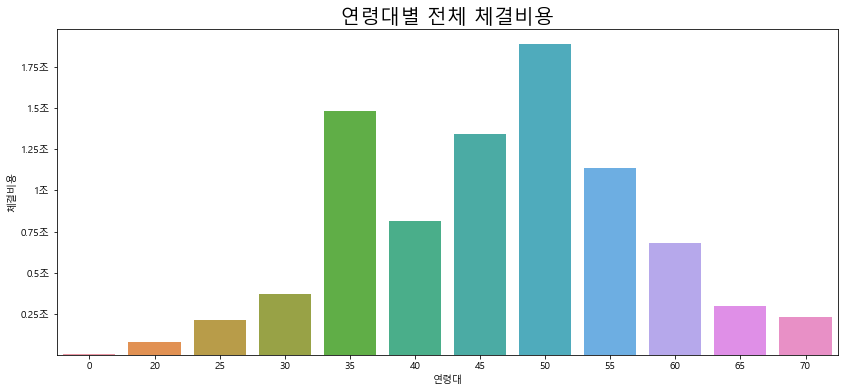

In [16]:
age_price = merge.groupby('연령대')['체결비용'].sum()
age_price = pd.DataFrame(age_price)
age_price = age_price.sort_values(by = '연령대')

x = age_price.index
y = age_price['체결비용']

fig, ax = plt.subplots(figsize = (14,6))
                       
sns.barplot(x,y)
ax.ticklabel_format(useOffset=False, style='plain', axis='y')

ax.set_yticks([250000000000,500000000000,750000000000,1000000000000,1250000000000,1500000000000,1750000000000])
ax.set_yticklabels(['0.25조', '0.5조', '0.75조', '1조', '1.25조', '1.5조', '1.75조'])

plt.title('연령대별 전체 체결비용', fontsize = 20)
# plt.savefig('연령대별 체', dpi = 300)
plt.show()

In [18]:
age_35 = merge[merge['연령대'] == 35]
age_35.index = range(len(age_35))
age_35['년월'] = age_35['주문날짜'].apply(lambda x : x.strftime('%Y%m'))

<ipython-input-18-620eef84af2a>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  age_35['년월'] = age_35['주문날짜'].apply(lambda x : x.strftime('%Y%m'))


### 2020년 4월부터 갑자기 거래비용이 널뛰기함

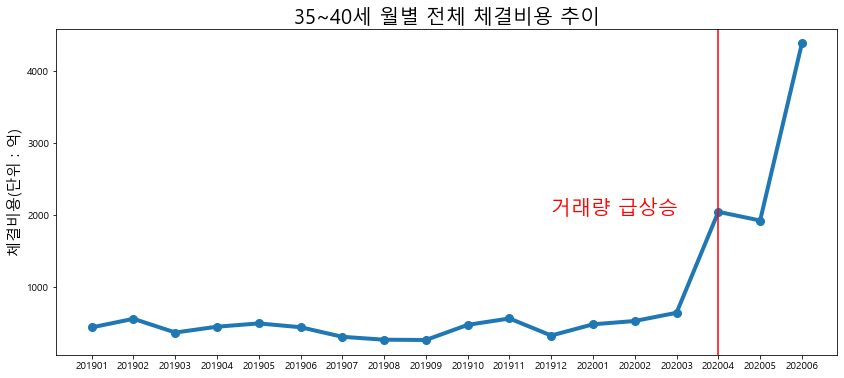

In [21]:
data = age_35.groupby(['년월'])['체결비용'].sum()
x = data.index
y = data/100000000

fig, ax = plt.subplots(figsize = (14,6))
ax.plot(x,y, lw = 4, marker = 'o', markersize = 8)
ax.set_ylabel('체결비용(단위 : 억)', fontsize = 15)
plt.title('35~40세 월별 전체 체결비용 추이', fontsize = 20)
plt.axvline(x = 15, color = 'red')
plt.text(11,2000, '거래량 급상승', fontsize= 20, color = 'red')
plt.show()

근데 전연령으로 보면 이미 코로나 터지고 1월부터 서서히 증가하고 있긴 했음

오히려 35~40은 더 늦은 4월에 갑자기 몰려든 느낌

In [24]:
merge['년월'] = ''
merge['년월'] = merge['주문날짜'].apply(lambda x : x.strftime('%Y%m'))

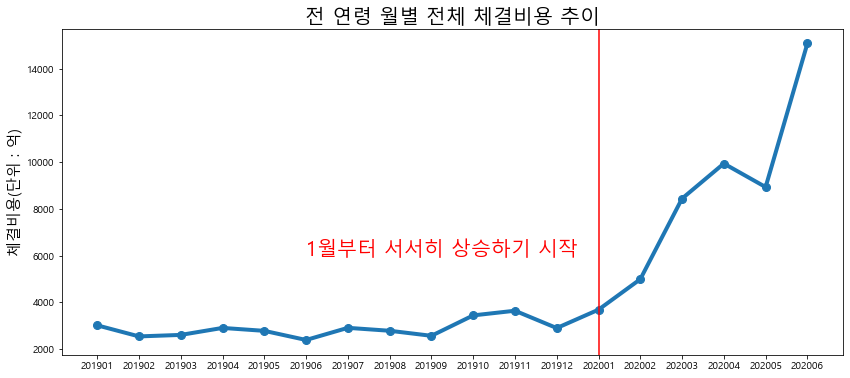

In [26]:
data = merge.groupby(['년월'])['체결비용'].sum()
x = data.index
y = data / 100000000

fig, ax = plt.subplots(figsize = (14,6))
ax.plot(x,y, lw = 4, marker = 'o', markersize = 8)
ax.set_ylabel('체결비용(단위 : 억)', fontsize = 15)
plt.title('전 연령 월별 전체 체결비용 추이', fontsize = 20)
plt.axvline(x = 12, color = 'red')
plt.text(5,6000, '1월부터 서서히 상승하기 시작', fontsize= 20, color = 'red')
plt.show()

전반적으로 모든 연령대에서 20년 이후 급격한 상승세를 보임

20세 미만과, 20 ~ 25 / 25 ~ 30 / 30 ~ 35 / 35 ~ 40 / 45 ~ 50 들은 2019년 12월 대비 2020년 6월에 5배 이상 증가했음!

이런 증가세가 새로운 투자자 유입량에 따른건지 기존 투자자들의 투자 금액이 커진건지 알아봐야 할 듯


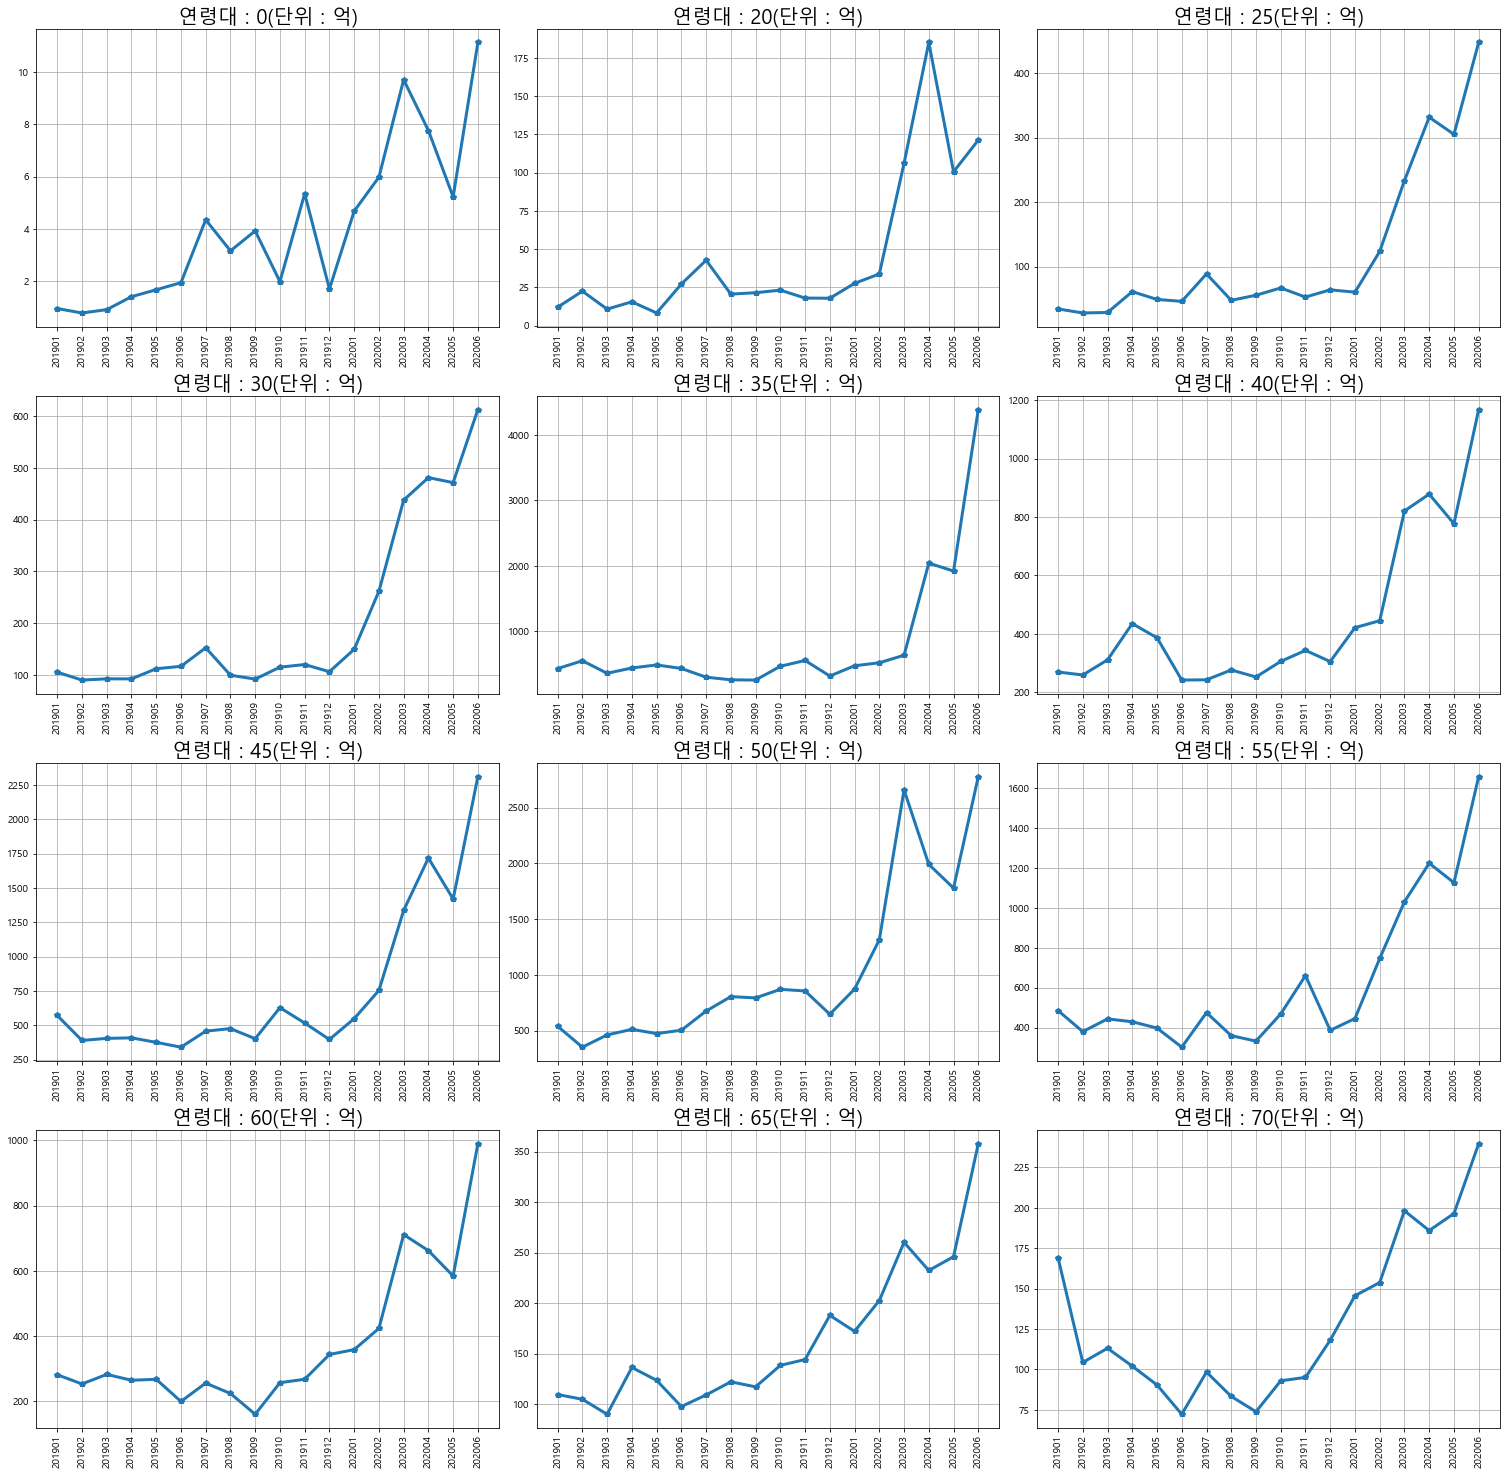

In [27]:
age_list = [0, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70]

fig, ax = plt.subplots(ncols = 3, nrows = 4, figsize = (21,20))
fig.tight_layout(h_pad = 5)
for i, age in enumerate(age_list):
    data = merge[merge['연령대'] == age]
    data = data.groupby(['년월'])['체결비용'].sum()
    
    
    
    col = i % 3
    row = i // 3
    
    x = data.index
    y = data/100000000
    
    ax[row,col].plot(x,y, lw = 3, marker = 'p')
    ax[row,col].set_xticks(range(len(x)))
    ax[row,col].set_xticklabels(x, rotation = 90)
    
    ax[row,col].set_title("연령대 : {0}(단위 : 억)".format(age), fontsize= 20)
    ax[row,col].grid()
# fig.savefig('연령대별 종목 총거래금액  Top5.png', dpi = 300, bbox_inches = "tight")

plt.show()

In [28]:
# 계좌 정보와 개인 정보를 병합
act_cus = pd.merge(act,cus, how ='left', left_on = 'cus_id', right_on = 'cus_id')

계좌를 몇십개씩 가지고 있는 애들.. 왜지?

In [29]:
act_cus['cus_id'].value_counts()

607b5194a54ec30991a86a4dee5a6e2a85924244fde2e0047d4917db2e93452f    69
ec428694f9bbe24e0591b205d1c266f5219b1794accb2c38e8278f3b9304bdb8    56
f595722537a7aac0ba585bd79dbf95a8f3a1a8d251500ba82e3e360fc0f245e9    52
5c698909252796a56118ddb12ed49dea5402cfd7c1960a5c97ecae772d4e5601    46
af887d5a0db31c53f761ea4ac34d33afa8572d892b2809ae5c97cdde78fe973e    45
                                                                    ..
bf9b080c3456925629f6bb06f49301ea0c4474c29030e5d176e9ebe60911090a     1
e3fb3641c18e5850e8114ec17f5455cd5a5fea104859516d0fdc0855e6981e79     1
b1602b85d4cce1958f8d3bc6d4c2422680486a3a4db073de1f6721ebdd9b70a7     1
972715b766607c037c65021876ee79be1dca1db9c7633a539295445525cc79f6     1
c6087ced9a44981296364b6da2f0d83ab46fe2fb6684fd66728e0de889d48fb3     1
Name: cus_id, Length: 10000, dtype: int64

### <월별 개설된 계좌 수>
#### 의도적으로 제공된 것인지는 모르지만 제공된 데이터들은 2020년 3월에 매우 많은 신규 계좌들이 생겨났고
#### 2020년 2월, 4월, 5월, 6월에도 많이 개설되었다가 7월에 들어서면서 다시 감소하는 추세를 보였다

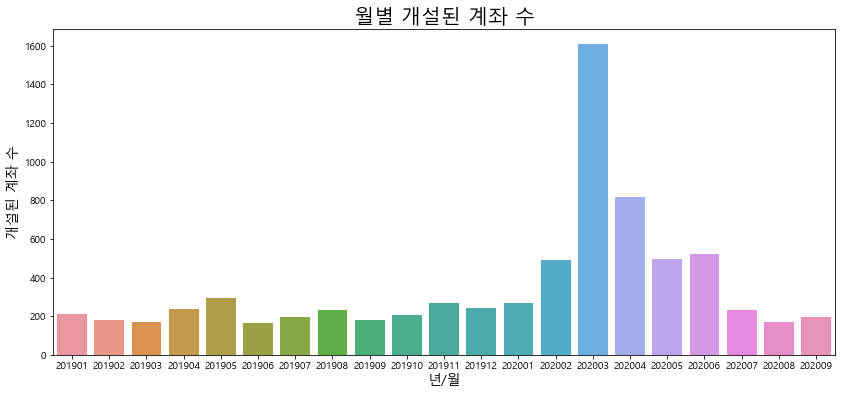

In [30]:
data = act_cus.groupby('act_opn_ym')['act_id'].count()[-22:-1]
x = data.index
y = data

fig, ax = plt.subplots(figsize = (14,6))

sns.barplot(x,y)

ax.set_title('월별 개설된 계좌 수', fontsize = 20)

ax.set_ylabel('개설된 계좌 수', fontsize = 14)
ax.set_xlabel('년/월', fontsize = 14)
plt.show()

### 20년 새로 유입된 이들과 기존 투자자들을 비교해보기 위해 분리

In [324]:
# 2020년 이전에 계좌 없었고 2020년에 처음 개설한 사람들. 진짜 유입들


act['2020년 개설'] = 0
act['2020년 이전 개설'] = 0

for i in range(len(act)):
    if act.loc[i,'act_opn_ym'] >= 202000:
        act.loc[i,'2020년 개설'] += 1
    else:
        act.loc[i,'2020년 이전 개설'] += 1
        
act_g = act.groupby(['cus_id'],as_index = False).agg({'2020년 개설' : 'sum', '2020년 이전 개설' : 'sum'})


new_cus = act_g[(act_g['2020년 개설'] != 0) & (act_g['2020년 이전 개설'] == 0)]
new_cus

,cus_id,2020년 개설,2020년 이전 개설
0,0005485133f45a0074dc4588abe1ae0fb6b3dfebded28b...,1,0
4,001f5ef83673487f2abf25efdd61e284adcc1953001e69...,1,0
12,0059fb03a31de0859efe39af9433c8c7b43291db1faad3...,4,0
14,006eea8d15906c421b52a3e96d4695e4f99e5e254269c1...,1,0
18,008be7e21a2b5bdf25e86f6d573f97abf9ddfa56c9c532...,1,0
...,...,...,...
9982,ff5fac7369638b3ec0bdc218206cee5783af013907cef1...,1,0
9988,ff9ef0d1a94e6e1ea16654943e6ab5775eef2fc0cde6fd...,1,0
9989,ffa66e795152e249e6848ccb8e06f71874b451c714fcc1...,1,0
9992,ffc00d5d8de0fa381e72c6de7a4d77b3d01218cd2a9093...,1,0


In [333]:
## 20년에 유입된 사람들
cus.loc[cus['cus_id'].isin(new_cus['cus_id'])].groupby(['cus_age'],as_index= False)['cus_id'].count()

,cus_age,cus_id
0,0,94
1,20,199
2,25,405
3,30,341
4,35,325
5,40,325
6,45,331
7,50,228
8,55,128
9,60,47


In [346]:
# 20년 이전 개설한 사람들

cus.drop(cus.loc[cus['cus_id'].isin(new_cus['cus_id'])].index).groupby(['cus_age'],as_index= False)['cus_id'].count()

,cus_age,cus_id
0,0,118
1,20,149
2,25,501
3,30,616
4,35,882
5,40,977
6,45,1165
7,50,1044
8,55,859
9,60,600


### 20대(z세대), 30대(y세대)의 유입 비율이 20년들어 크게 상승했다
### 반면, 50대와 60대에서 큰 폭으로 감소했음을 볼 수 있었다.
#### 하지만, 이것이 전체 집단 데이터가 아니라 일부 표본만을 가져온 데이터이므로 비율이 유지된 것인지 알기는 힘들다

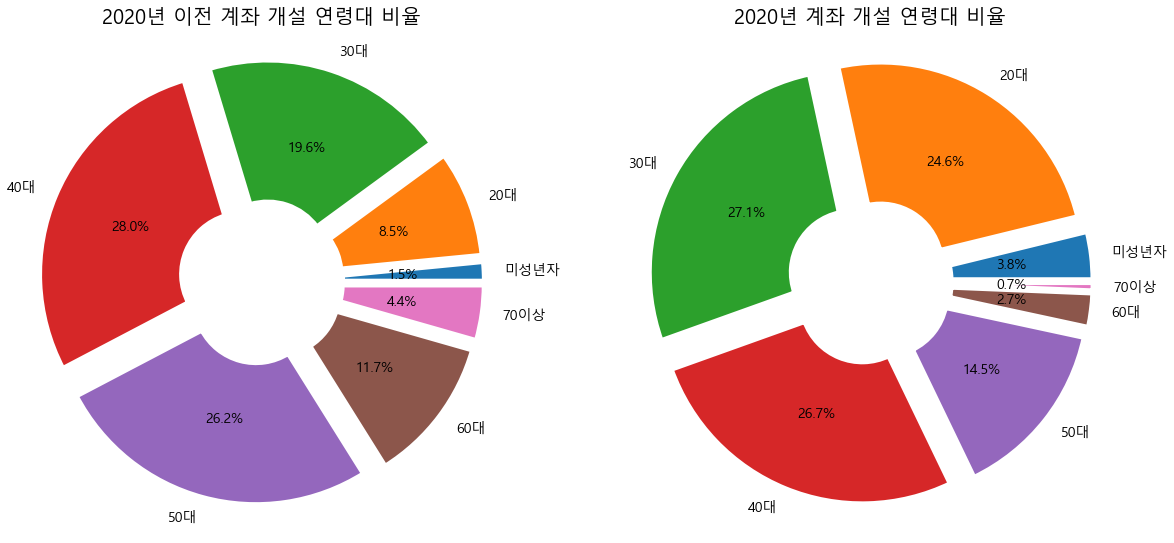

In [348]:
act_cus['년'] = ''
act_cus['년'] = act_cus['act_opn_ym'].apply(lambda x : str(x)[:4])

act_cus_age_num = act_cus.groupby(['년','cus_age'], as_index = False)['act_id'].count()
act_cus_age_num = act_cus_age_num[act_cus_age_num['년'].isin(['2018','2019','2020'])]

act_cus_age_num_2019 = {'미성년자' : 118,
'20대' : 650,
'30대' : 1498,
'40대' : 2142,
'50대' : 2003,
'60대' : 892,
'70이상' : 338}

act_cus_age_num_2020 = {'미성년자' : 94,
'20대' : 604,
'30대' : 666,
'40대' : 656,
'50대' : 356,
'60대' : 67,
'70이상' : 16}

act_cus_age_num_2019 = pd.DataFrame(data = act_cus_age_num_2019.values(), index = act_cus_age_num_2019.keys())
act_cus_age_num_2020 = pd.DataFrame(data = act_cus_age_num_2020.values(), index = act_cus_age_num_2020.keys())

act_cus_age_num_2019['비율'] = act_cus_age_num_2019[0] / act_cus_age_num_2019[0].sum() * 100
act_cus_age_num_2020['비율'] = act_cus_age_num_2020[0] / act_cus_age_num_2020[0].sum() * 100

fig,ax = plt.subplots(figsize = (20,10), ncols = 2, nrows = 1)

y = act_cus_age_num_2019['비율']
x = act_cus_age_num_2019.index

explode = [0.1,0.1,0.1,0.1,0.1,0.1,0.1]
wedgeprops={'width': 0.7, 'edgecolor': 'w', 'linewidth': 5}
textprops={'fontsize' : 14}

ax[0].pie(y, labels = x, autopct='%0.1f%%', explode = explode, wedgeprops = wedgeprops, textprops = textprops)
ax[0].set_title('2020년 이전 계좌 개설 연령대 비율', fontsize = 20)



y = act_cus_age_num_2020['비율']
x = act_cus_age_num_2020.index

explode = [0.1,0.1,0.1,0.1,0.1,0.1,0.1]
wedgeprops={'width': 0.7, 'edgecolor': 'w', 'linewidth': 5}
textprops={'fontsize' : 14}

ax[1].pie(y, labels = x, autopct='%0.1f%%', explode = explode, wedgeprops = wedgeprops, textprops = textprops)
ax[1].set_title('2020년 계좌 개설 연령대 비율', fontsize = 20)
plt.show()

### 그렇다면 20년대 계좌 개설한 사람들은 어디다 투자를 했을까?
### 20년 개설한 사람들과 그 이전에 계좌 개설한 사람들간의 투자한 종목을 비교해보았다

두드러지게 보여지는 차이점은 20년 이전 개설한 집단(old)은 ETF, 그것도 '증권상장지수투자지수' 가 상위 두 종목을 차지하고 있는 반면, 20년 유입된 집단(young)은 삼성전자 보통주가 큰 차이로 1순위이다.

또, young 집단은 old 집단의 순위권에서는 보이지 않는 원유 선물 인버스/레버리지가 Top 4,5를 차지하고 있다는게 특이하다. 원유로 유입된 사람들이 많나?

또한, old에서는 20위권인 카카오가 young에서는 3위를 차지. 이외에도 old에서는 보이지 않는 빅텍 등이 상위권을 차지하고 있음

In [370]:
opn20_act = list(set((act.loc[act['cus_id'].isin(new_cus['cus_id']),:])['act_id'])) # 20년대 유입된 사람들 계좌번호
opn20_act_trd = merge[merge['계좌번호'].isin(opn20_act)]

ex_opn20_act_trd = merge.drop(opn20_act_trd.index) # 20년 이전부터 투자한 사람들
ex_opn20_act_trd = ex_opn20_act_trd[ex_opn20_act_trd['년'] == 2020] # 20년 거래량만 취급

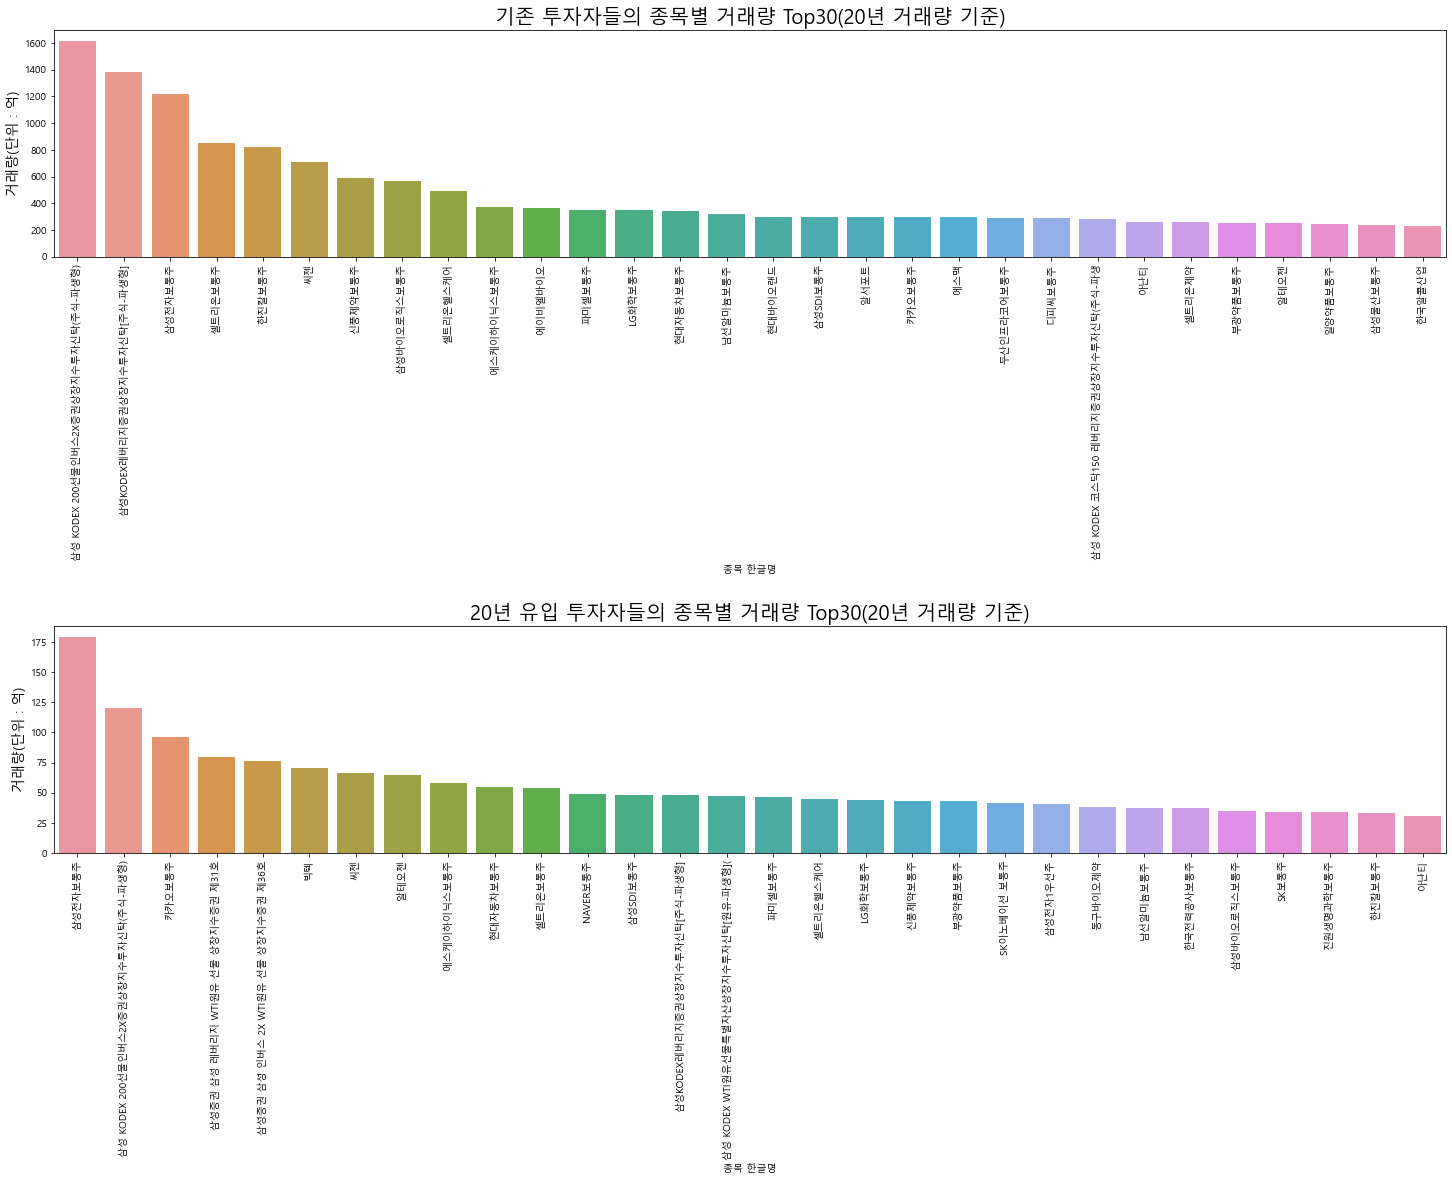

In [372]:
iem_price_ex_opn20 = ex_opn20_act_trd.groupby('종목 한글명')['체결비용'].sum().sort_values(ascending = False)[:30]
iem_price_ex_opn20 = pd.DataFrame(iem_price_ex_opn20)

x = iem_price_ex_opn20.index
y = iem_price_ex_opn20['체결비용'] / 100000000

fig, (ax1,ax2) = plt.subplots(figsize = (20,12), nrows = 2)
fig.tight_layout(h_pad = 35)    


sns.barplot(x,y, ax = ax1)
# ax[0].ticklabel_format(useOffset=False, style='plain', axis='y')
ax1.set_xticks(range(len(x)))
ax1.set_xticklabels(x, rotation = 90)
# ax.set_yticks([50000000000,100000000000,150000000000,200000000000,250000000000])
# ax.set_yticklabels(['500억', '1000억', '1500억', '2000억', '2500억'])
ax1.set_ylabel('거래량(단위 : 억)', fontsize= 14)
ax1.set_title('기존 투자자들의 종목별 거래량 Top30(20년 거래량 기준)', fontsize = 20)
# plt.savefig('20년 계좌 개설한 사람들의 종목별 거래량 Top20.png', dpi = 300)
# plt.show()

iem_price_opn20 = opn20_act_trd.groupby('종목 한글명')['체결비용'].sum().sort_values(ascending = False)[:30]
iem_price_opn20 = pd.DataFrame(iem_price_opn20)

x = iem_price_opn20.index
y = iem_price_opn20['체결비용'] / 100000000


                       
sns.barplot(x,y, ax = ax2)
# ax[1].ticklabel_format(useOffset=False, style='plain', axis='y')
ax2.set_xticks(range(len(x)))
ax2.set_xticklabels(x, rotation = 90)
# ax.set_yticks([50000000000,100000000000,150000000000,200000000000,250000000000])
# ax.set_yticklabels(['500억', '1000억', '1500억', '2000억', '2500억'])
ax2.set_ylabel('거래량(단위 : 억)', fontsize= 14)
ax2.set_title('20년 유입 투자자들의 종목별 거래량 Top30(20년 거래량 기준)', fontsize = 20)
# plt.savefig('20년 계좌 개설한 사람들의 종목별 거래량 Top20.png', dpi = 300)
plt.show()

In [53]:
data = merge[(merge['종목 한글명'] == '삼성전자보통주') & (merge['매매구분코드'] == 2)]
data = data.groupby(['주문날짜']).agg({'체결비용' : 'sum',
                                 '체결수량' : 'sum'})

In [54]:
data

,체결비용,체결수량
주문날짜,,
2019-01-02,16146550.00000,416.00000
2019-01-03,153533000.00000,4035.00000
2019-01-04,261236700.00000,7038.00000
2019-01-07,3142750.00000,82.00000
2019-01-08,47000450.00000,1220.00000
...,...,...
2020-06-24,1622087300.00000,30453.00000
2020-06-25,584721300.00000,11153.00000
2020-06-26,220582900.00000,4146.00000


In [67]:
# 종목명을 입력하면 2019년 1월부터 총 매수 금액이 그려지는 함수

def plot_iem_buy_price(iem):
    fig, ax = plt.subplots(figsize = (20,6))

    data = merge[(merge['종목 한글명'] == iem) & (merge['매매구분코드'] == 2)]
    data= data.groupby(['주문날짜']).agg({'체결비용' : 'sum',
                                     '체결수량' : 'sum'})
    x = data.index
    y = data['체결비용'] / 100000000
    sns.lineplot(x,y)
    ax.set_ylabel('총체결비용(단위 : 억)')
    ax.set_title('종목 : {0} 체결비용'.format(iem), fontsize = 20)

    
# 종목명을 입력하면 2019년 1월부터 총 매수 수량이 그려지는 함수
def plot_iem_buy_qty(iem):
    fig, ax = plt.subplots(figsize = (20,6))

    data = merge[(merge['종목 한글명'] == iem) & (merge['매매구분코드'] == 2)]
    data= data.groupby(['주문날짜']).agg({'체결비용' : 'sum',
                                     '체결수량' : 'sum'})
    x = data.index
    y = data['체결수량']

    sns.lineplot(x,y)
    ax.set_ylabel('총체결비용')
    ax.set_title('종목 : {0} 체결수량'.format(iem), fontsize = 20)

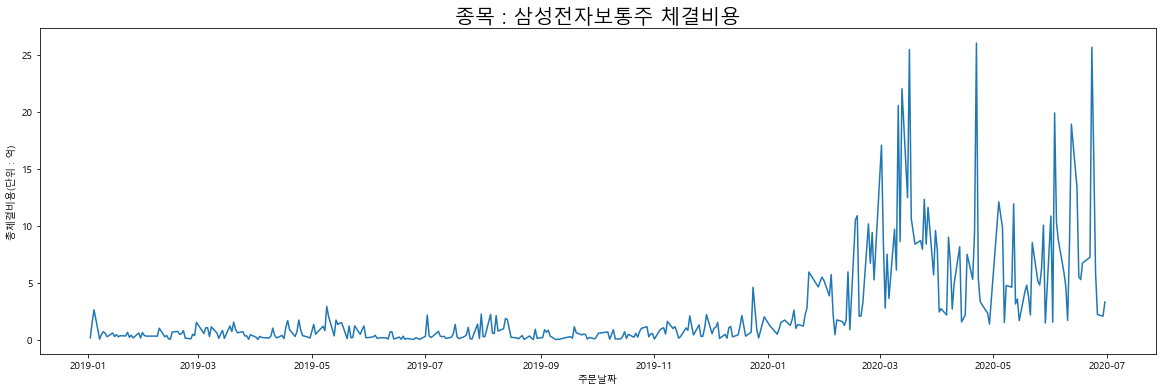

In [85]:
# 예시

plot_iem_buy_price('삼성전자보통주')

### 종목별 총 거래금액 Top 30

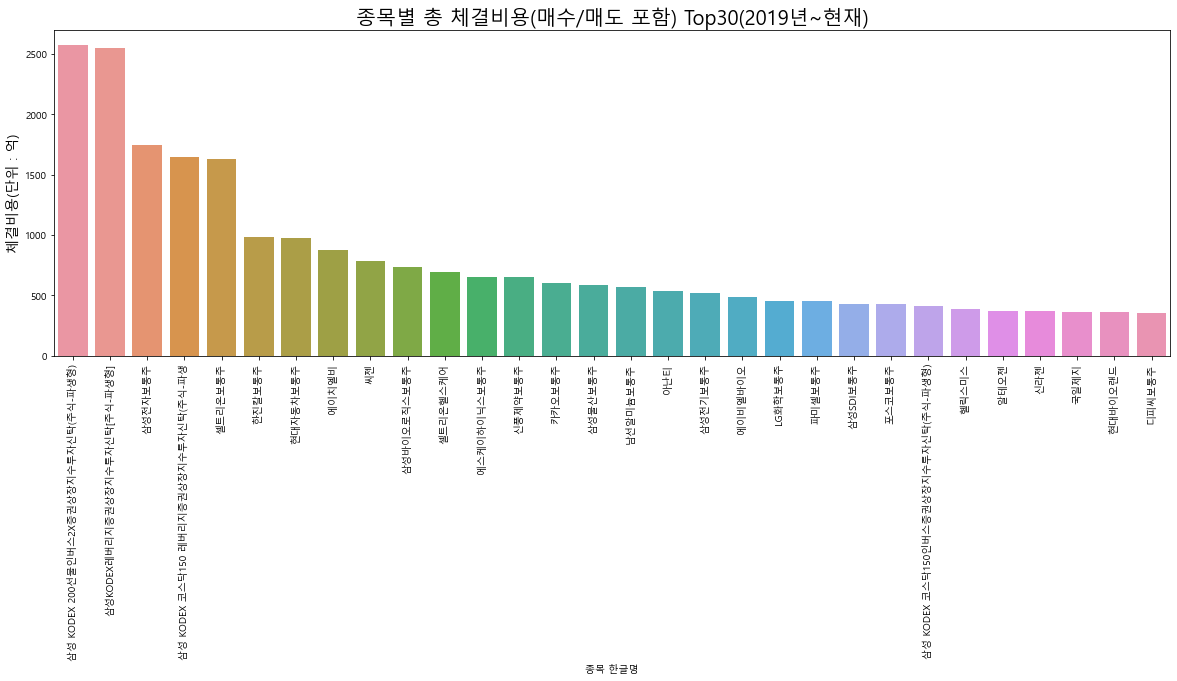

In [73]:
iem_price = merge.groupby('종목 한글명')['체결비용'].sum().sort_values(ascending = False)[:30]
iem_price = pd.DataFrame(iem_price)

x = iem_price.index
y = iem_price['체결비용'] / 100000000

fig, ax = plt.subplots(figsize = (20,6))
                       
sns.barplot(x,y)
ax.ticklabel_format(useOffset=False, style='plain', axis='y')
ax.set_xticks(range(len(x)))
ax.set_xticklabels(x, rotation = 90)
# ax.set_yticks([50000000000,100000000000,150000000000,200000000000,250000000000])
# ax.set_yticklabels(['500억', '1000억', '1500억', '2000억', '2500억'])
ax.set_ylabel('체결비용(단위 : 억)', fontsize= 14)
plt.title('종목별 총 체결비용(매수/매도 포함) Top30(2019년~현재)', fontsize = 20)
# plt.savefig('종목별 총거래금액(매수_매도 포함) Top30.png', dpi = 300)
plt.show()


In [78]:
iem_list = list(set(merge['종목 한글명']))
ETF_list = ['KODEX', 'TIGER', 'KBSTAR', 'ARIRANG', 'KINDEX', 'KOSEF']
ETF_name = []

for iem in iem_list:
    for ETF in ETF_list:
        if ETF in iem:
            ETF_name.append(iem)

# ETF 만 거래한 것들
ETF = merge[merge['종목 한글명'].isin(ETF_name)]
ETF.columns = ['계좌번호', '주문순서', '주문접수시간대', '최종체결시간대', '종목코드', '매매구분코드', '체결수량', '체결가격',
       '주문매체구분코드', '주문날짜', '년', '월', '일', '체결비용', '종목 영어명',
       '종목 한글명', '종목명(보통주_우선주 제외)', '보통주/우선주', 
       '고객번호', '계좌 개설 년월', '성별', '연령대', '주소(시도)', '고객등급', '고객투자성향',
       '소요시간(최종체결시간대 - 주문접수시간대)', '년월']
# ETF 제외하고 거래한 것들
drop_ETF = merge.drop(ETF.index)

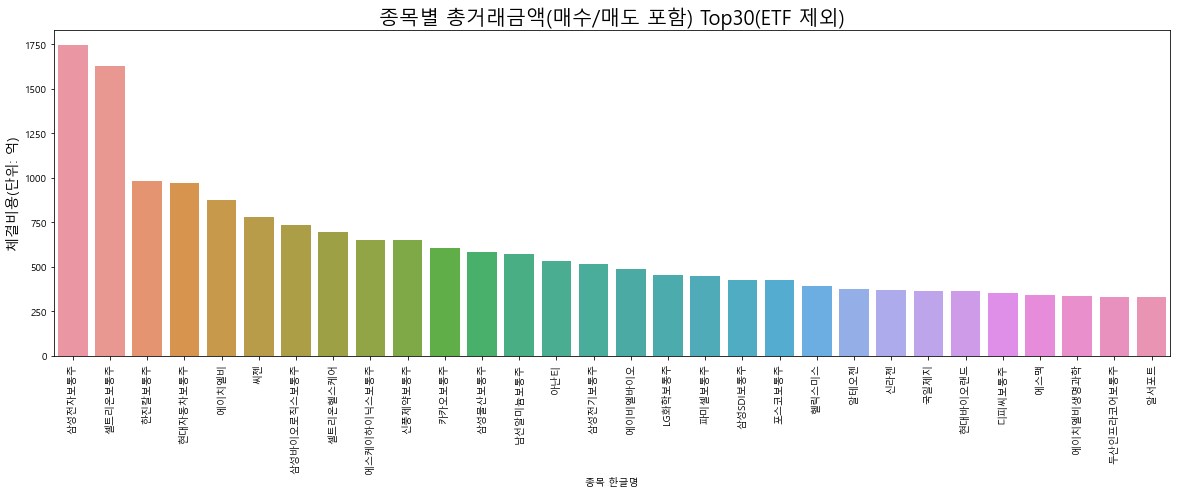

In [83]:
iem_price_ex_ETF = drop_ETF.groupby('종목 한글명')['체결비용'].sum().sort_values(ascending = False)[:30]
iem_price_ex_ETF = pd.DataFrame(iem_price_ex_ETF)

x = iem_price_ex_ETF.index
y = iem_price_ex_ETF['체결비용'] / 100000000

fig, ax = plt.subplots(figsize = (20,6))
                       
sns.barplot(x,y)
ax.ticklabel_format(useOffset=False, style='plain', axis='y')
ax.set_xticks(range(len(x)))
ax.set_xticklabels(x, rotation = 90)
ax.set_ylabel('체결비용(단위: 억)', fontsize = 14)
plt.title('종목별 총거래금액(매수/매도 포함) Top30(ETF 제외)', fontsize = 20)
plt.savefig('종목별 총거래금액(매수_매도 포함) Top30(ETF 제외).png', dpi = 300)
plt.show()


In [86]:
age_iem_price = merge.groupby(['연령대','종목 한글명'], as_index = False).agg({'체결비용' : 'sum'})

In [87]:
age_iem_price

,연령대,종목 한글명,체결비용
0,0,(주)마이크로컨텍솔루션,22325295.00000
1,0,AK홀딩스보통주,260550.00000
2,0,BGF리테일보통주,5540500.00000
3,0,CJ씨푸드1우선주,358800.00000
4,0,CJ씨푸드보통주,3127690.00000
...,...,...,...
25460,70,흥국화재해상보험2우선주(신형),4527800.00000
25461,70,흥국화재해상보험보통주,2968220.00000
25462,70,흥아해운보통주,3282.00000
25463,70,희림종합건축사사무소,1136140.00000


In [243]:
# age_list = [0, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70]

# fig, ax = plt.subplots(ncols = 3, nrows = 4, figsize = (21, 32))
# fig.tight_layout(h_pad = 30)
# for i,age in enumerate(age_list):
#     data = age_iem_price[age_iem_price['연령대'] == age]
#     data.loc[:,'비율'] = data.loc[:,'체결비용'] / data.loc[:,'체결비용'].sum() * 100
#     data = data.sort_values(by = '비율', ascending = False)[:5]
    
#     col = i % 3
#     row = i // 3
    
#     x = data['종목 한글명']
#     y = data['비율']
    
#     ax[row,col].bar(x,y)
#     ax[row,col].set_xticks(range(len(x)))
#     ax[row,col].set_xticklabels(x, rotation = 90, fontsize = 10)
    
#     ax[row,col].set_title("연령대 : {0}".format(age), fontsize= 20)
# # fig.savefig('연령대별 종목 총거래금액  Top5.png', dpi = 300, bbox_inches = "tight")
# plt.show()

55세 이상부터는 ETF가 아예 사라지거나 비율이 적어지는 것을 볼 수 있었음

55세 이하에서는 전 연령대에 걸쳐 전반적으로 ETF 비중이 높은 것을 확인(미성년자 제외)

In [128]:
# 20대는 z세대 , 30대는 y세대, 40 이상은 old, 미성년자는 young으로 구분

generation = {
    0 : 'young',
    20 : 'z',
    25 : 'z',
    30 : 'y',
    35 : 'y',
    40 : 'old',
    45 : 'old',
    50 : 'old',
    55 : 'old',
    60 : 'old',
    65 : 'old',
    70 : 'old'
}
merge['세대'] = merge['연령대'].apply(lambda x : generation[x])

In [133]:
generation_trd = merge.groupby(['세대', '종목 한글명', '매매구분코드'], as_index = False).agg({'체결비용' : ['sum', 'count'], '체결수량' : 'sum'})
generation_trd.head(10)

세대        종목 한글명 매매구분코드             체결비용               체결수량
                                         sum count          sum
0  old  (주)마이크로컨텍솔루션      1  143079705.00000    81  42184.00000
1  old  (주)마이크로컨텍솔루션      2  136569235.00000    95  38851.00000
2  old     (주)스카이이앤엠      1  358566240.00000   117 115582.00000
3  old     (주)스카이이앤엠      2  450958875.00000   214 133409.00000
4  old      (주)포스코엠텍      1 3781321180.00000   963 536748.00000
5  old      (주)포스코엠텍      2 3968341970.00000  1617 549681.00000
6  old     AJ네트웍스보통주      1  105487970.00000    64  27009.00000
7  old     AJ네트웍스보통주      2  102106195.00000   130  25588.00000
8  old      AK홀딩스보통주      1  198068050.00000    75   6275.00000
9  old      AK홀딩스보통주      2  283164000.00000   240   8984.00000

## 세대 별, 매수 Top30

z세대, y세대, old 세대 모두 증권상장지수투자신탁(ETF)가 상위권에 위치.

그러나 z세대의 경우, 유일하게 원유 선물 상품이 3위, 11위에 위치.

z세대의 경우, 선물 인버스 2X가, y세대의 경우, 코스닥 레버리지가 큰 차이로 1순위. -> 어떤 의미인지 스터디 필요



1. z세대 : 현대자동차, 삼성전자

2. y세대 : 에이비엘바이오

3. old : 셀트리온, 삼전

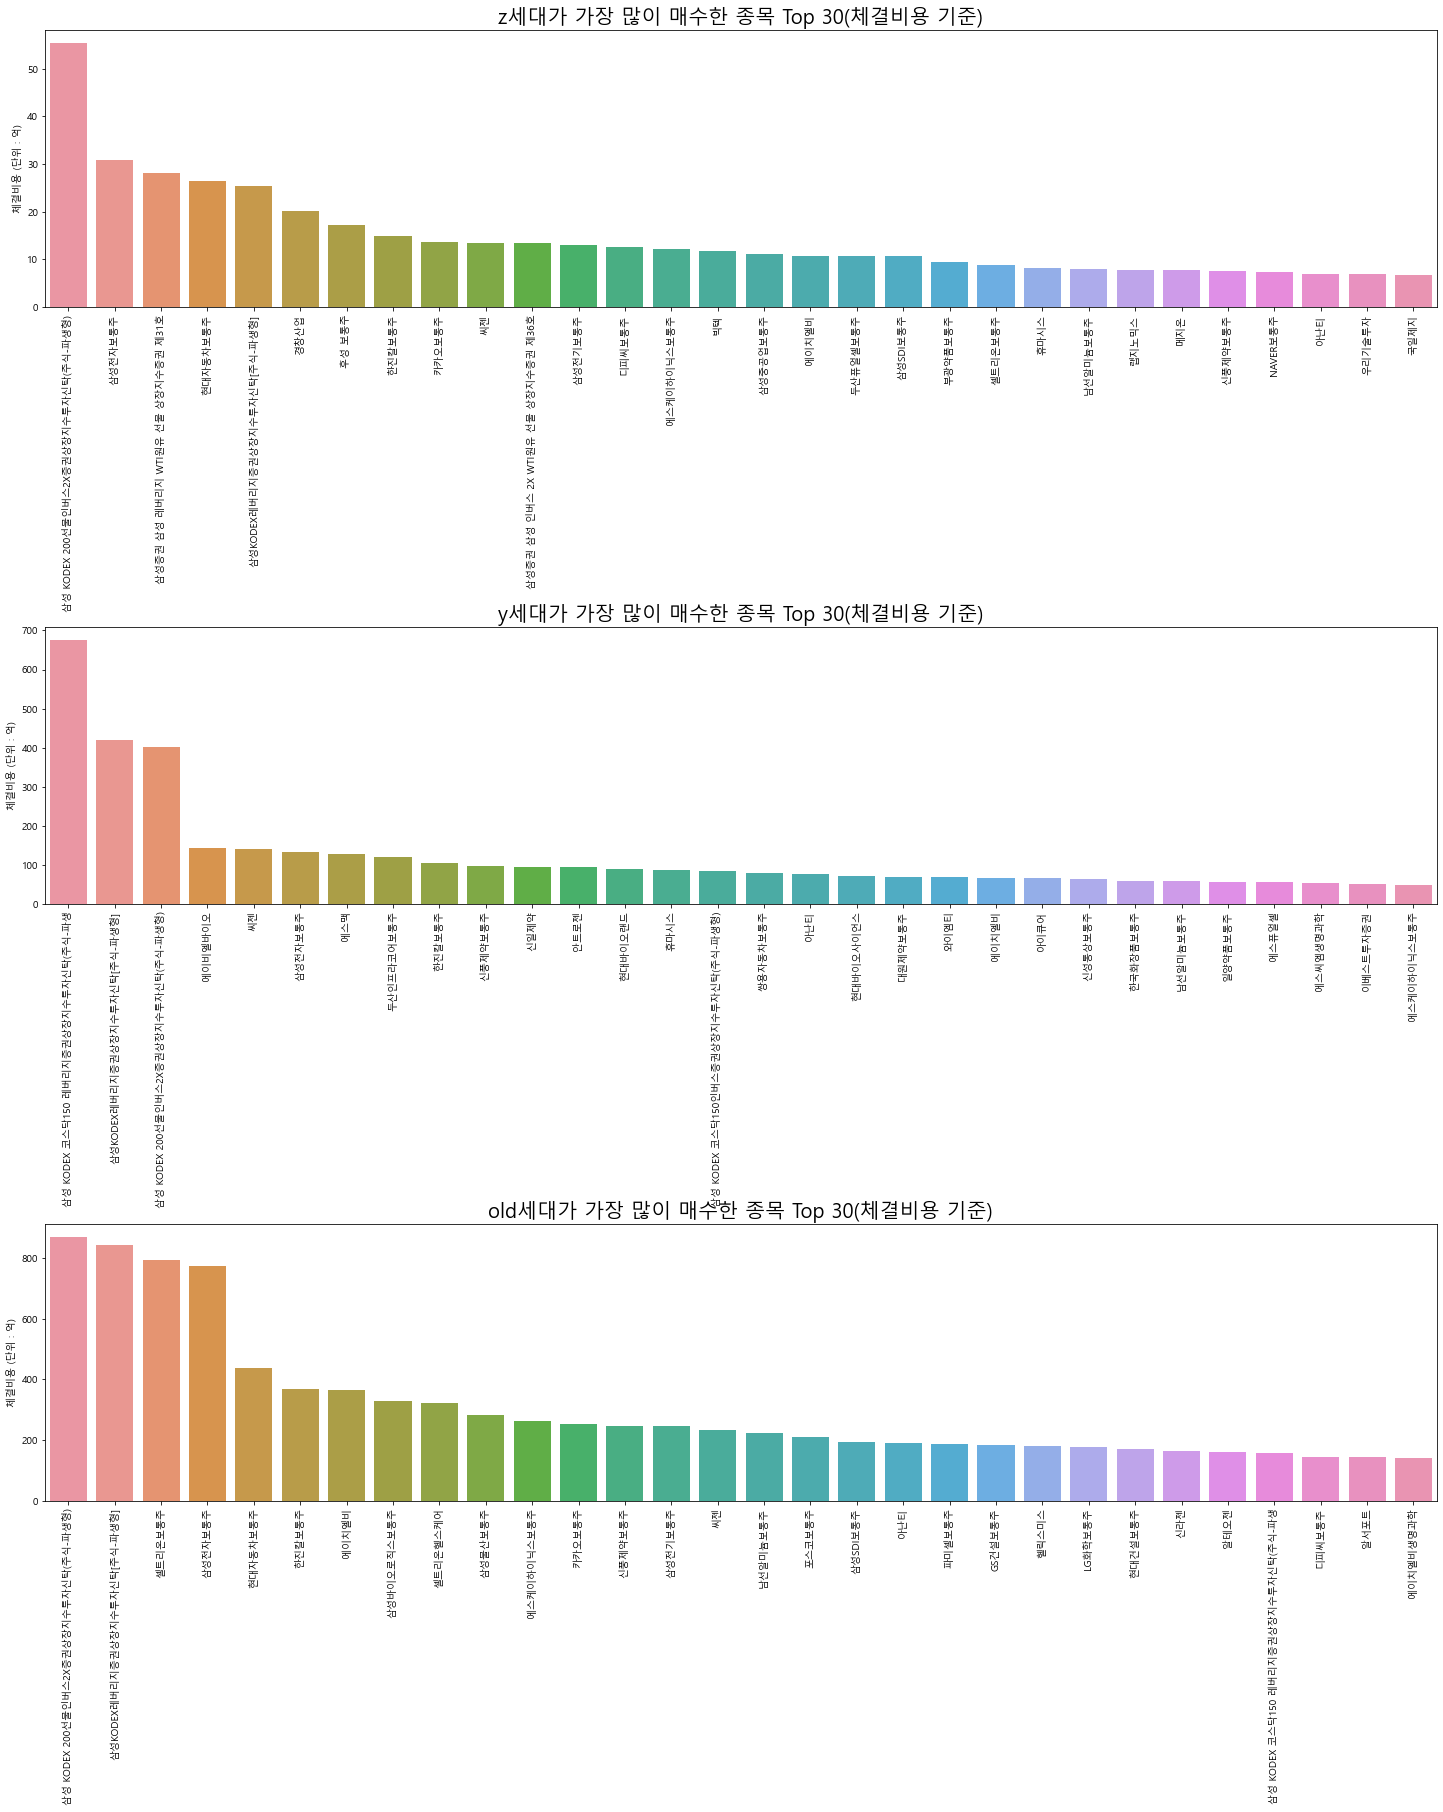

In [155]:
# y세대가 가장 많이 매수한 종목(체결비용 기준)
data = generation_trd[(generation_trd['세대'] == 'z') & (generation_trd['매매구분코드'] == 2)].sort_values(by = ('체결비용', 'sum'), ascending = False)[:30]


fig, (ax1,ax2, ax3) = plt.subplots(figsize  = (20,21), nrows = 3)
fig.tight_layout(h_pad = 30)
x = data['종목 한글명']
y = data[('체결비용', 'sum')] / 100000000

sns.barplot(x,y, ax= ax1)

ax1.set_xticks(range(len(x)))
ax1.set_xticklabels(x, rotation = 90)
ax1.set_ylabel('체결비용 (단위 : 억)')
ax1.set_title('z세대가 가장 많이 매수한 종목 Top 30(체결비용 기준)', fontsize = 20)
ax1.set_xlabel('')


data = generation_trd[(generation_trd['세대'] == 'y') & (generation_trd['매매구분코드'] == 2)].sort_values(by = ('체결비용', 'sum'), ascending = False)[:30]

x = data['종목 한글명']
y = data[('체결비용', 'sum')] / 100000000


sns.barplot(x,y, ax= ax2)

ax2.set_xticks(range(len(x)))
ax2.set_xticklabels(x, rotation = 90)
ax2.set_ylabel('체결비용 (단위 : 억)')
ax2.set_title('y세대가 가장 많이 매수한 종목 Top 30(체결비용 기준)', fontsize = 20)
ax2.set_xlabel('')



data = generation_trd[(generation_trd['세대'] == 'old') & (generation_trd['매매구분코드'] == 2)].sort_values(by = ('체결비용', 'sum'), ascending = False)[:30]


x = data['종목 한글명']
y = data[('체결비용', 'sum')] / 100000000

sns.barplot(x,y, ax= ax3)

ax3.set_xticks(range(len(x)))
ax3.set_xticklabels(x, rotation = 90)
ax3.set_ylabel('체결비용 (단위 : 억)')
ax3.set_title('old세대가 가장 많이 매수한 종목 Top 30(체결비용 기준)', fontsize = 20)
ax3.set_xlabel('')

plt.show()

### y세대, z세대, old세대의 거래 금액 추이

아무래도 개인 소득이 없거나 적은 z세대가 가장 낮은 차트를 보임

y세대의 경우 x세대나 old세대에 비해 넓은 신뢰구간 면적을 보이는데 개인소득의 편차와 그로 인한 투자금액의 분포가 넓기 때문인듯? 결혼 유무도 자금의 편차에 영향이 있을듯

old 세대의 경우, 200 ~ 300만원 선에서 거의 일정한 차트를 보임.

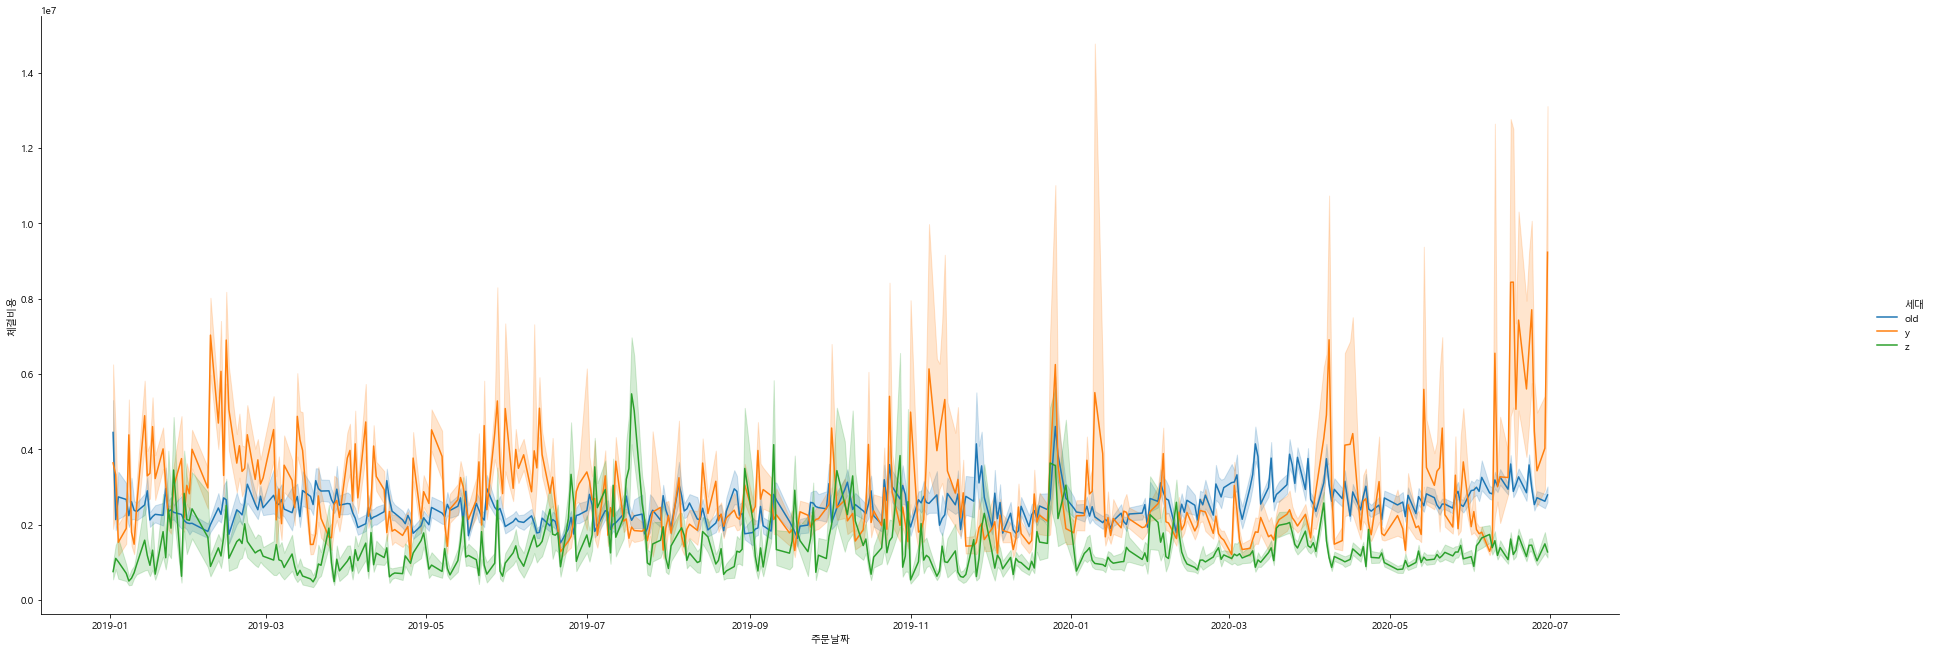

In [231]:
data = merge[ (merge['세대'] != 'young') ]



g = sns.relplot(data = data, x = '주문날짜',y = '체결비용',hue = '세대', markers = True, kind = 'line')

g.fig.set_size_inches(30,10)